In [128]:
import os
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
import matplotlib.pyplot as plt

In [105]:
# Set working directory here
WD = '/Users/johnmichael/Documents/vm-spinal-risk/vm-spinal-risk'

In [106]:
df = pd.read_csv(os.path.join(WD, 'data/normative_odi_processed.csv'))

In [107]:
df.head()

,record_id,risk_1_timestamp,age,sex,height,weight,zipcode,ethnicity,income,education,...,state_code,province,province_code,latitude,longitude,fips,GISJOIN,FIPS,ADI_NATRANK,ADI_STATERNK
0,3,1/26/2024 22:04,25,1,18,36,76177,4,4,6,...,TX,Tarrant,439.0,32.9448,-97.3124,4.843911e+11,G48043901139401,4.843911e+11,34,2
1,4,1/26/2024 22:04,31,1,23,131,94041,5,6,7,...,CA,Santa Clara,85.0,37.3893,-122.0783,6.085510e+10,G06008505096003,6.085510e+10,1,1
2,5,1/26/2024 22:05,35,1,22,66,11221,5,8,6,...,NY,Kings,47.0,40.6907,-73.9274,3.604704e+11,G36004700387001,3.604704e+11,13,4
3,6,1/26/2024 22:04,28,1,25,77,32226,4,13,6,...,FL,Duval,31.0,30.4735,-81.5448,1.203101e+11,G12003100101071,1.203101e+11,55,6
4,7,1/26/2024 22:06,35,1,24,91,60074,7,18,10,...,IL,Cook,31.0,42.1458,-88.0230,1.703180e+11,G17003108036112,1.703180e+11,52,5


In [108]:
df.dropna(subset=['latitude', 'longitude'], inplace=True)

In [109]:
df_counts = df.groupby('state_code')['record_id'].count().reset_index()
df_counts

,state_code,record_id
0,AL,14
1,AR,8
2,AZ,18
3,CA,103
4,CO,10
5,CT,10
6,DC,2
7,DE,3
8,FL,60
9,GA,16


In [125]:
# Create a base map centered around the US
us_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add points to the map based on the DataFrame
for index, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']]
    ).add_to(us_map)
us_map

/var/folders/tt/_pp9kyh90nb8r_kmk9y99nsw0000gn/T/ipykernel_81077/4149914434.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, orientation="horizontal", aspect=50, fraction=0.005, pad=0)


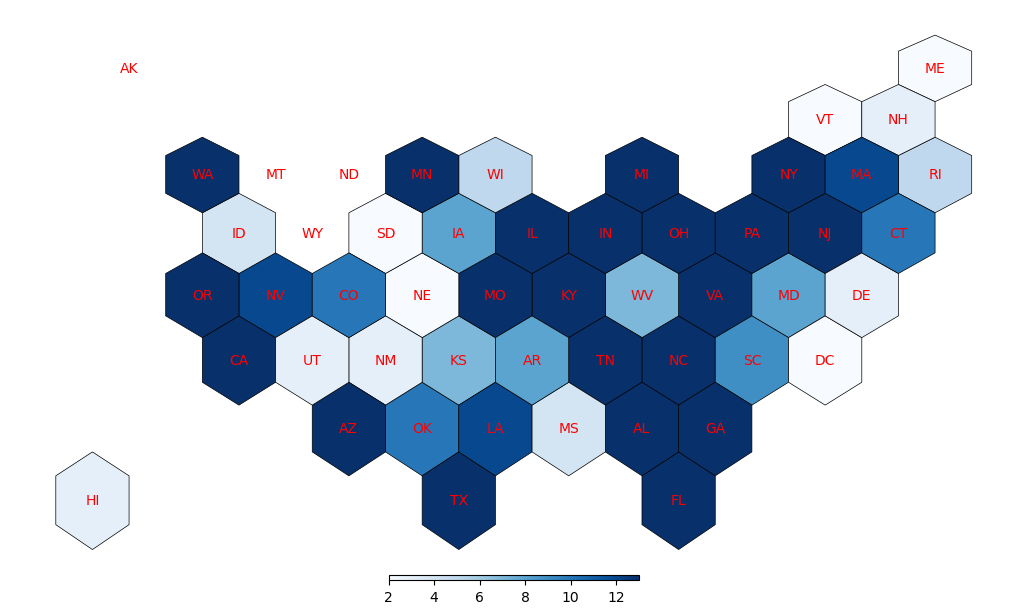

In [149]:
# Load file
url = "https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/us_states_hexgrid.geojson.json"
geoData = gpd.read_file(url)

# add a "centroid" column with the centroid position of each county
geoData['centroid'] = geoData['geometry'].apply(lambda x: x.centroid)
    
# Merge the mariage dataset with the geospatial information
geoData = geoData.set_index('iso3166_2').join(df_counts.set_index('state_code'))
geoData.reset_index(inplace=True)

# Initialize the figure
fig, ax = plt.subplots(1, figsize=(13, 13))

# map counties with the right color:
geoData.plot(
    ax=ax,
    column='record_id', 
    cmap='Blues', 
    norm=plt.Normalize(vmin=2, vmax=13),
    edgecolor='black', 
    linewidth=.5
);

# Remove useless axis
ax.axis('off');

# for each county, annotate with the county name located at the centroid coordinates 
for idx, row in geoData.iterrows():
    ax.annotate(
        text=row['iso3166_2'], 
        xy=row['centroid'].coords[0], 
        horizontalalignment='center', 
        va='center',
        color="red"
    )

# Add a color bar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=2, vmax=13))
fig.colorbar(sm, orientation="horizontal", aspect=50, fraction=0.005, pad=0)